# **<span style='color:#E1B12D'>SUMMARY OF THE PREVIOUS ITERATION</span>**

#### The experiments for iterations 1-6 can be accessed through the following links, representing different stages of model experimentation and refinement: <br>
https://docs.google.com/document/d/10WGPwrBJ9mru7Dapz0NnE3UoKPmkzcg0/edit?usp=sharing&ouid=108130443603744974649&rtpof=true&sd=true


## **Iterasi 7**

**Summary**

1. Complete details of this iteration can be found in this Google Colab Notebook.

2. Methodological errors identified in previous iterations have been corrected in this iteration.

3. Overall, after conducting hyperparameter tuning experiments, the models demonstrate optimal performance. This is evident from:
   - Significant improvements in the Recall metric without compromising other metrics.
   - Calculation results indicating the most optimal impact on the business context.

In [ ]:
# Import library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# **1. <span style='color:#E1B12D'>LOAD DATA </span>**

In [ ]:
# Download data from Google Drive
!gdown --id 1wg4vHsB_X3Qvv-Y6DSHAiSbTCkVereHH

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wg4vHsB_X3Qvv-Y6DSHAiSbTCkVereHH
To: /content/df2_processed(2).csv
100% 9.22M/9.22M [00:00<00:00, 37.6MB/s]


In [ ]:
# Renaming the file if necessary
df = pd.read_csv('df2_processed(2).csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,default_loan_interaction,housing_loan_interaction,default_housing_loan_interaction,duration_prev_interaction,contact_quarter,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,euribor3m_bin,nr.employed_bin
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,no_no,no_no,no_no_no,261.0,2,> 1,93 - 94,-40 - (-35),> 4.5,5100 - 5200
1,37,services,married,high.school,no,yes,no,telephone,may,mon,...,no_no,yes_no,no_yes_no,226.0,2,> 1,93 - 94,-40 - (-35),> 4.5,5100 - 5200
2,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,no_no,no_no,no_no_no,151.0,2,> 1,93 - 94,-40 - (-35),> 4.5,5100 - 5200
3,56,services,married,high.school,no,no,yes,telephone,may,mon,...,no_yes,no_yes,no_no_yes,307.0,2,> 1,93 - 94,-40 - (-35),> 4.5,5100 - 5200
4,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,no_no,no_no,no_no_no,139.0,2,> 1,93 - 94,-40 - (-35),> 4.5,5100 - 5200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                30478 non-null  int64  
 1   job                                30478 non-null  object 
 2   marital                            30478 non-null  object 
 3   education                          30478 non-null  object 
 4   default                            30478 non-null  object 
 5   housing                            30478 non-null  object 
 6   loan                               30478 non-null  object 
 7   contact                            30478 non-null  object 
 8   month                              30478 non-null  object 
 9   day_of_week                        30478 non-null  object 
 10  duration                           30478 non-null  int64  
 11  campaign                           30478 non-null  int

# **2. <span style='color:#E1B12D'>EDA & PRE-PROCESSING FOR MODELLING</span>**

## **2.1 <span style='color:#E1B12D'> Describe Data  </span>**

In [ ]:
# Identifying numerical features
nums = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identifying categorical features
cats = df.select_dtypes(include=['object']).columns.tolist()

In [ ]:
df[nums].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,duration_prev_interaction,contact_quarter
count,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000
mean,39.029694,259.513124,2.521721,956.318295,0.194337,-0.071425,93.523376,-40.602579,3.459976,5160.813967,237.477457,2.602008
std,10.332746,261.746393,2.720495,201.404843,0.522862,1.610306,0.585366,4.788790,1.777215,75.158267,253.239380,0.743608
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,1.000000
25%,31.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.313000,5099.100000,89.000000,2.000000
50%,37.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.856000,5191.000000,160.000000,2.000000
75%,45.000000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,291.000000,3.000000
max,95.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,4918.000000,4.000000


**Explanation**

Based on the descriptive statistics, there is a possibility of outliers in the `duration` feature, which has a very wide range of values. However, since we will be using a model that is robust to outliers, we can disregard this issue. Additionally, the `duration` feature may be somewhat ambiguous in a business context, so it needs to be considered carefully before being included in the model.

In [ ]:
# Descriptive statistics for all categorical features
pd.set_option('display.max_columns', None)  # Display all columns
df[cats].describe(include='all')


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y,age_bin,job_marital_interaction,job_education_interaction,marital_education_interaction,job_marital_education_interaction,default_housing_interaction,default_loan_interaction,housing_loan_interaction,default_housing_loan_interaction,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,euribor3m_bin,nr.employed_bin
count,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478
unique,11,3,7,2,2,2,2,10,5,3,2,5,33,70,20,194,4,3,4,6,4,3,6,4,4
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no,Dewasa,admin._married,admin._university.degree,married_university.degree,admin._married_university.degree,no_yes,no_no,yes_no,no_yes_no,> 1,93 - 94,-45 - (-40),> 4.5,5200 - 5300
freq,8734,17487,10408,30475,16516,25710,20435,9731,6391,25826,26620,13818,4256,5006,5350,2322,16515,25707,13673,13672,16153,19007,11620,16238,11216


**Explanation**

The `y` feature appears to be imbalanced, with the "no" value occurring much more frequently (around 25,826 times) compared to the "yes" value (around 4,652 times). Balancing will be necessary in the next steps to ensure that the model can learn effectively from both classes.

## **2.2 <span style='color:#E1B12D'> Correlation & Remove Features </span>**

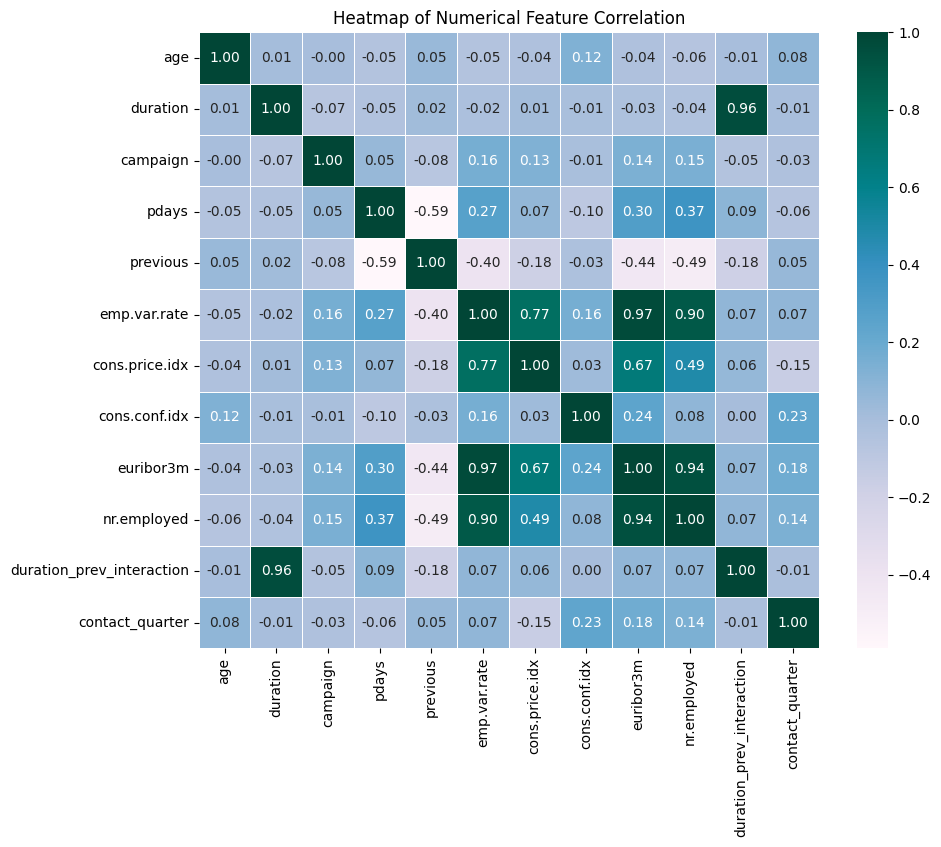

In [ ]:
# Identifying numerical features
nums = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Creating a correlation matrix of numerical features
correlation_matrix = df[nums].corr()

# Creating a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='PuBuGn', linewidths=0.5)

# Adding a title
plt.title('Heatmap of Numerical Feature Correlation')

# Displaying the heatmap
plt.show()


**Explanation**

Since we will be using a model capable of handling multicollinearity, such as XGBoost, features with high correlation do not need to be removed. This model can automatically address multicollinearity issues without impacting its performance, allowing all features to be retained for a more comprehensive analysis.

However, XGBoost may prioritize features that provide more direct information during decision tree splits, and features that seem theoretically important may not always be indicated as the most significant in the model if other highly correlated features dominate the data splits. Therefore, we will still proceed with the decision to remove features with high correlation not based on multicollinearity but on business context, where there is one feature that has a high correlation with the target and is also theoretically important.

Nevertheless, concerns about losing information can be resolved since the features that are being removed have already been binned, thus providing the same information.

In [ ]:
# Features to be removed
features_to_remove = ['duration_prev_interaction', 'duration', 'emp.var.rate', 'nr.employed']

# Removing features from the dataset
df = df.drop(columns=features_to_remove)

**Explanation**

The features `'duration_prev_interaction'` and `'duration'` are removed because, in a business context, both of these features can introduce bias. `'duration_prev_interaction'` is measured after the previous interaction and may not reflect conditions that are relevant for the current analysis. Similarly, `'duration'` may not provide meaningful additional information since the duration of previous calls does not always have a direct correlation with the outcomes of the current campaign. By removing these features, we avoid potential distortion in the analysis and ensure that the model focuses on more relevant and impactful variables.

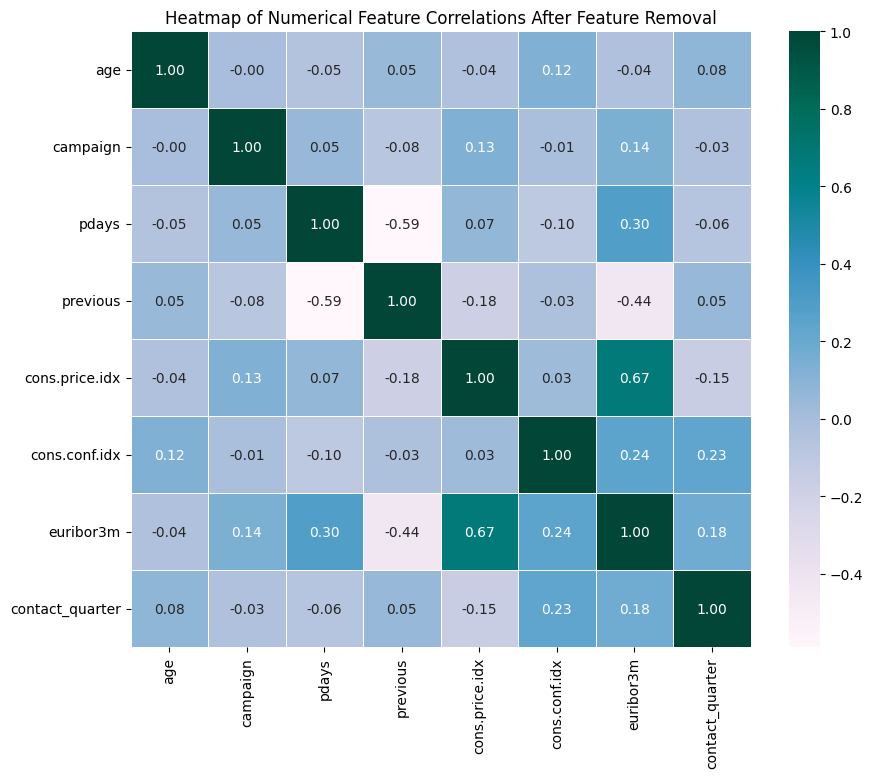

In [ ]:
# Identifying numerical features
nums = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Creating a correlation matrix from numerical features
correlation_matrix = df[nums].corr()

# Creating a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='PuBuGn', linewidths=0.5)

# Adding a title
plt.title('Heatmap of Numerical Feature Correlations After Feature Removal')

# Displaying the heatmap
plt.show()


## **2.3 <span style='color:#E1B12D'> Encoding Categorical Features </span>**

In [ ]:
# Descriptive statistics for all categorical features
pd.set_option('display.max_columns', None)  # Display all columns
df[cats].describe(include='all')


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y,age_bin,job_marital_interaction,job_education_interaction,marital_education_interaction,job_marital_education_interaction,default_housing_interaction,default_loan_interaction,housing_loan_interaction,default_housing_loan_interaction,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,euribor3m_bin,nr.employed_bin
count,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478,30478
unique,11,3,7,2,2,2,2,10,5,3,2,5,33,70,20,194,4,3,4,6,4,3,6,4,4
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no,Dewasa,admin._married,admin._university.degree,married_university.degree,admin._married_university.degree,no_yes,no_no,yes_no,no_yes_no,> 1,93 - 94,-45 - (-40),> 4.5,5200 - 5300
freq,8734,17487,10408,30475,16516,25710,20435,9731,6391,25826,26620,13818,4256,5006,5350,2322,16515,25707,13673,13672,16153,19007,11620,16238,11216


**Explanation**

1. **Remove features with many unique values**: Remove features that have too many unique values, such as job_marital_interaction, job_education_interaction, marital_education_interaction, job_marital_education_interaction, default_housing_interaction, default_loan_interaction, housing_loan_interaction, and default_housing_loan_interaction.

2. **One-hot encoding**: Apply to features with a relatively small number of unique values and without a logical order, such as job, marital, contact, poutcome, education, month, day_of_week, and age_bin. One-hot encoding transforms each category into separate binary columns (0 or 1), allowing the model to handle categorical features without considering the order among categories.

3. **Label encoding**: Use for features that have unique values with ordinal or relational order, such as contact_quarter, emp.var.rate_bin, cons.price.idx_bin, cons.conf.idx_bin, euribor3m_bin, nr.employed_bin, as well as default, housing, and loan. Label encoding provides a numerical representation that preserves the order or relational context among categories.

In [ ]:
# List of columns to be removed
features_to_remove = [
    'job_marital_interaction', 'job_education_interaction', 'marital_education_interaction',
    'job_marital_education_interaction', 'default_housing_interaction', 'default_loan_interaction',
    'housing_loan_interaction', 'default_housing_loan_interaction'
]

# Removing features from the dataset
df = df.drop(columns=features_to_remove)

# List of features for one-hot encoding
one_hot_features = ['job', 'marital', 'contact', 'poutcome', 'education', 'month', 'day_of_week', 'age_bin']

# Defining the encoding order according to the provided order
encoding_order = {
    'contact_quarter': [1, 2, 3, 4],
    'emp.var.rate_bin': ['> 1', '-2 - 0', '-3 - (-2)', '< -3'],
    'cons.price.idx_bin': ['93 - 94', '94 - 95', '92 - 93'],
    'cons.conf.idx_bin': ['-40 - (-35)', '-45 - (-40)', '-50 - (-45)', '-55 - (-50)', '-35 - (-30)', '> -30'],
    'euribor3m_bin': ['> 4.5', '3 - 4.5', '1 - 3', '0 - 1'],
    'nr.employed_bin': ['5200 - 5300', '5100 - 5200', '5000 - 5100', '4900 - 5000'],
    'default': ['no', 'yes'],
    'housing': ['no', 'yes'],
    'loan': ['no', 'yes']
}

# Separating the target
target = df['y']
df_cleaned = df.drop(columns=['y'])

# One-hot encoding for features with many unique values
df = pd.get_dummies(df, columns=one_hot_features)

# Label encoding for features with the defined order
for feature, order in encoding_order.items():
    if feature in df.columns:
        df[feature] = pd.Categorical(df[feature], categories=order, ordered=True)
        df[feature] = df[feature].cat.codes

# Label encoding for the target
target_encoder = LabelEncoder()
df['y'] = target_encoder.fit_transform(target.astype(str))


In [ ]:
# Convert all columns of type bool to int
df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            30478 non-null  int64  
 1   default                        30478 non-null  int8   
 2   housing                        30478 non-null  int8   
 3   loan                           30478 non-null  int8   
 4   campaign                       30478 non-null  int64  
 5   pdays                          30478 non-null  int64  
 6   previous                       30478 non-null  int64  
 7   cons.price.idx                 30478 non-null  float64
 8   cons.conf.idx                  30478 non-null  float64
 9   euribor3m                      30478 non-null  float64
 10  y                              30478 non-null  int64  
 11  contact_quarter                30478 non-null  int8   
 12  emp.var.rate_bin               30478 non-null 

## **2.4 <span style='color:#E1B12D'> Changes 'pdays' Values </span>**

In [ ]:
# Replace 999 with 0 in the 'pdays' column
df['pdays'] = df['pdays'].replace(999, 0)

In [ ]:
unique_pdays = df['pdays'].unique()
print(unique_pdays)

[ 0  6  4  5  1  3 10  7  9 11  8  2 12 13 14 15 16 21 17 18 22 25 26 19
 27]


In [ ]:
pd.set_option('display.max_columns', None)

display(df.head())

,age,default,housing,loan,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,y,contact_quarter,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,euribor3m_bin,nr.employed_bin,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,age_bin_Dewasa,age_bin_Dewasa Tua,age_bin_Lansia,age_bin_Muda,age_bin_Tua
0,56,0,0,0,1,0,0,93.994,-36.4,4.857,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,37,0,1,0,1,0,0,93.994,-36.4,4.857,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
2,40,0,0,0,1,0,0,93.994,-36.4,4.857,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,56,0,0,1,1,0,0,93.994,-36.4,4.857,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
4,59,0,0,0,1,0,0,93.994,-36.4,4.857,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0


## **2.5 <span style='color:#E1B12D'> Data Split </span>**

In [ ]:
# Separating features and target
X = df.drop(columns=['y'])  # Removing the target column
y = df['y']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## **2.6 <span style='color:#E1B12D'> Handle Class Imbalance </span>**

In [ ]:
# Counting the number of each class in the training target data
class_counts = y_train.value_counts()

# Displaying the results
print("Number of class 0:", class_counts.get(0, 0))
print("Number of class 1:", class_counts.get(1, 0))


Number of class 0: 18661
Number of class 1: 2673


**Explanation**  
With class 0 having a count of 18,661 and class 1 having a count of 2,673, the class imbalance in the dataset is quite significant. In this situation, using **incremental SMOTE** or **SMOTE on a subset** can be more effective than total oversampling, and here are the reasons:

1. **Better Control**: Incremental SMOTE allows for gradual adjustment of the oversampling ratio, enabling more careful balancing of the data as needed.

2. **Reducing the Risk of Overfitting**: Total oversampling can increase the risk of overfitting because the model may learn excessively from synthetic data. With incremental SMOTE or batch processing, the amount of synthetic data added can be monitored and adjusted to avoid overfitting.

3. **Quality of Synthetic Data**: Applying SMOTE gradually allows for a greater focus on the quality of the synthetic data generated, ensuring that the new data remains relevant and does not negatively affect the distribution of the original data.

In [ ]:
# Applying SMOTE only on a subset of the data or batch
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Checking the class distribution after oversampling
print(f'Count of class 0 after oversampling: {y_train_resampled.value_counts()[0]}')
print(f'Count of class 1 after oversampling: {y_train_resampled.value_counts()[1]}')


Count of class 0 after oversampling: 18661
Count of class 1 after oversampling: 18661


In [ ]:
# Counting the number of each class in the target training data
class_counts = y_test.value_counts()

# Displaying the results
print("Count of class 0:", class_counts.get(0, 0))
print("Count of class 1:", class_counts.get(1, 0))


Count of class 0: 7959
Count of class 1: 1185


# **3. <span style='color:#E1B12D'> MODELLING </span>**

**Evaluation Metrics in the Context of Bank Deposit Business**

1. **Precision:** The proportion of true positive predictions.
2. **Recall:** The proportion of actual positives that were successfully predicted.
3. **F1-Score:** The harmonic mean of Precision and Recall.
4. **ROC-AUC:** Measures the model's ability to distinguish between positive and negative classes.
5. **Accuracy:** The proportion of total correct predictions.

**Focus on Recall and ROC-AUC**

* **Recall:** Very important to minimize missed business opportunities. With high Recall, the bank can identify most potential customers.
* **ROC-AUC:** Ideal for imbalanced data and provides a comprehensive overview of model performance.

**Further Explanation**

* **Recall:** If Recall is high, it means the model successfully identifies most customers who will actually open a deposit. This is important because we do not want to lose potential customers.
* **ROC-AUC:** ROC-AUC provides a more comprehensive picture compared to Accuracy, especially when the data classes are imbalanced (e.g., the number of customers opening deposits is much smaller). ROC-AUC measures the model's ability to differentiate between the positive class (will open a deposit) and the negative class (will not open a deposit) for various possible thresholds.

In [ ]:
def eval_classification(model, X_train_resampled, y_train_resampled, X_test, y_test):
    # Predictions on the test and train set
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train_resampled)

    # Probability predictions on the test and train set
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train_resampled)

    # Calculate and print evaluation metrics for the test set
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train_resampled, y_pred_train))

    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Precision (Train Set): %.2f" % precision_score(y_train_resampled, y_pred_train))

    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train_resampled, y_pred_train))

    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("F1-Score (Train Set): %.2f" % f1_score(y_train_resampled, y_pred_train))

    # Calculate and print ROC-AUC for the test set
    print("ROC-AUC (Test Set - Proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("ROC-AUC (Train Set - Proba): %.2f" % roc_auc_score(y_train_resampled, y_pred_proba_train[:, 1]))

    # Cross-validation for Precision, Recall, F1-Score, and ROC-AUC
    cv_results = cross_validate(
        model,
        X_train_resampled,
        y_train_resampled,
        cv=5,
        scoring={'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'roc_auc': 'roc_auc'},
        return_train_score=True
    )

    print('Precision (Cross-Val Train): %.2f' % cv_results['train_precision'].mean())
    print('Precision (Cross-Val Test): %.2f' % cv_results['test_precision'].mean())
    print('Recall (Cross-Val Train): %.2f' % cv_results['train_recall'].mean())
    print('Recall (Cross-Val Test): %.2f' % cv_results['test_recall'].mean())
    print('F1-Score (Cross-Val Train): %.2f' % cv_results['train_f1'].mean())
    print('F1-Score (Cross-Val Test): %.2f' % cv_results['test_f1'].mean())
    print('ROC-AUC (Cross-Val Train): %.2f' % cv_results['train_roc_auc'].mean())
    print('ROC-AUC (Cross-Val Test): %.2f' % cv_results['test_roc_auc'].mean())

def show_feature_importance(model, X):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(60).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('Feature Importance Score')
    plt.show()

def show_best_hyperparameter(model):
    if hasattr(model, 'best_estimator_'):
        print(model.best_estimator_.get_params())
    else:
        print("Model does not have the attribute 'best_estimator_'")


In [ ]:
def draw_learning_curve(param_values, model_name, model_class, param_name, param_range):
    train_scores = []
    test_scores = []

    for param_value in param_values:
        if model_name == 'SVM':
            model = model_class(C=param_value, probability=True)  # Use 'probability=True' to get probabilities
        else:
            model = model_class(**{param_name: param_value})
        model.fit(X_train_resampled, y_train_resampled)

        # Evaluate on training data
        y_pred_train_proba = model.predict_proba(X_train_resampled)[:, 1] if model_name != 'SVM' else model.decision_function(X_train_resampled)
        train_auc = roc_auc_score(y_train_resampled, y_pred_train_proba)
        train_scores.append(train_auc)

        # Evaluate on test data
        y_pred_proba = model.predict_proba(X_test)[:, 1] if model_name != 'SVM' else model.decision_function(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba)
        test_scores.append(test_auc)

        print(f'Param value: {param_value}; Train AUC: {train_auc}; Test AUC: {test_auc}')

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel(param_name)
    plt.ylabel('AUC')
    plt.title(f'Learning Curve - Hyperparameter {param_name} - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def show_feature_importance(model, X):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    top_10_features = feat_importances.nlargest(10)

    # Create a colormap from dark green to light blue
    cmap = plt.get_cmap('PuBuGn')
    colors = [cmap(i / len(top_10_features)) for i in range(len(top_10_features)-1, -1, -1)]  # Reverse gradient

    ax = top_10_features.plot(kind='barh', figsize=(10, 8), color=colors)
    ax.invert_yaxis()

    # Display values at the end of the bars
    for i, v in enumerate(top_10_features):
        ax.text(v + 0.01, i, f'{v:.2f}', va='center')  # Add value at the end of the bar

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Top 10 Feature Importance Scores')
    plt.show()


## **3.1 <span style='color:#E1B12D'> Logistic Regression </span>**

In [ ]:
# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Train the model with the training data
logreg.fit(X_train, y_train)

# Evaluate the model
eval_classification(logreg, X_train_resampled, y_train_resampled, X_test, y_test)

Accuracy (Test Set): 0.88
Accuracy (Train Set): 0.60
Precision (Test Set): 0.66
Precision (Train Set): 0.93
Recall (Test Set): 0.22
Recall (Train Set): 0.21
F1-Score (Test Set): 0.33
F1-Score (Train Set): 0.35
ROC-AUC (Test Set - Proba): 0.80
ROC-AUC (Train Set - Proba): 0.80
Precision (Cross-Val Train): 0.94
Precision (Cross-Val Test): 0.94
Recall (Cross-Val Train): 0.87
Recall (Cross-Val Test): 0.84
F1-Score (Cross-Val Train): 0.91
F1-Score (Cross-Val Test): 0.86
ROC-AUC (Cross-Val Train): 0.95
ROC-AUC (Cross-Val Test): 0.94


**Explanation**

The model results indicate overall good performance; however, a lower recall compared to precision suggests a weakness in detecting all positive cases (deposits). This means that the model tends to be better at avoiding false positives (incorrectly predicting a deposit) but may still miss some deposit cases (false negatives).

In the context of a bank's deposit business, a low recall can lead to missed opportunities to convert potential customers. Therefore, even though precision and ROC-AUC are high, the focus should be on improving recall to ensure that more positive cases can be detected, without sacrificing too much on other metrics.

In [ ]:
# Map coefficients to feature names
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]  # Use logreg.coef_ directly
})

# Sort features by coefficient values (in descending order)
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print(coef_df)


              Feature  Coefficient
34   poutcome_success     0.589434
47          month_mar     0.460271
45          month_jul     0.387869
46          month_jun     0.291738
15    nr.employed_bin     0.251817
..                ...          ...
31  contact_telephone    -0.236402
53    day_of_week_mon    -0.270614
9           euribor3m    -0.357153
32   poutcome_failure    -0.648810
48          month_may    -0.844656

[62 rows x 2 columns]


## **3.2 <span style='color:#E1B12D'> Random Forest </span>**

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier()

# Train the model with the training data
rf.fit(X_train, y_train)

# Evaluate the model
eval_classification(rf, X_train_resampled, y_train_resampled, X_test, y_test)

# Reset warning settings to default
warnings.filterwarnings('default')


Accuracy (Test Set): 0.88
Accuracy (Train Set): 0.75
Precision (Test Set): 0.55
Precision (Train Set): 1.00
Recall (Test Set): 0.30
Recall (Train Set): 0.51
F1-Score (Test Set): 0.39
F1-Score (Train Set): 0.67
ROC-AUC (Test Set - Proba): 0.79
ROC-AUC (Train Set - Proba): 0.97
Precision (Cross-Val Train): 1.00
Precision (Cross-Val Test): 0.94
Recall (Cross-Val Train): 1.00
Recall (Cross-Val Test): 0.91
F1-Score (Cross-Val Train): 1.00
F1-Score (Cross-Val Test): 0.91
ROC-AUC (Cross-Val Train): 1.00
ROC-AUC (Cross-Val Test): 0.98


**Explanation**

These results indicate a potential overfitting issue. Precision, recall, F1-score, and ROC-AUC on the training data reached 1.00, suggesting that the model predicts almost perfectly on the training data. However, there is a performance drop on the test data, particularly in recall (0.91) and F1-score (0.91), which, although still good, indicates that the model may be "memorizing" the training data rather than generalizing well.

A significant difference between training and test performance is often a sign of overfitting. The model is too accurate on the training data, and its performance declines when applied to new data.

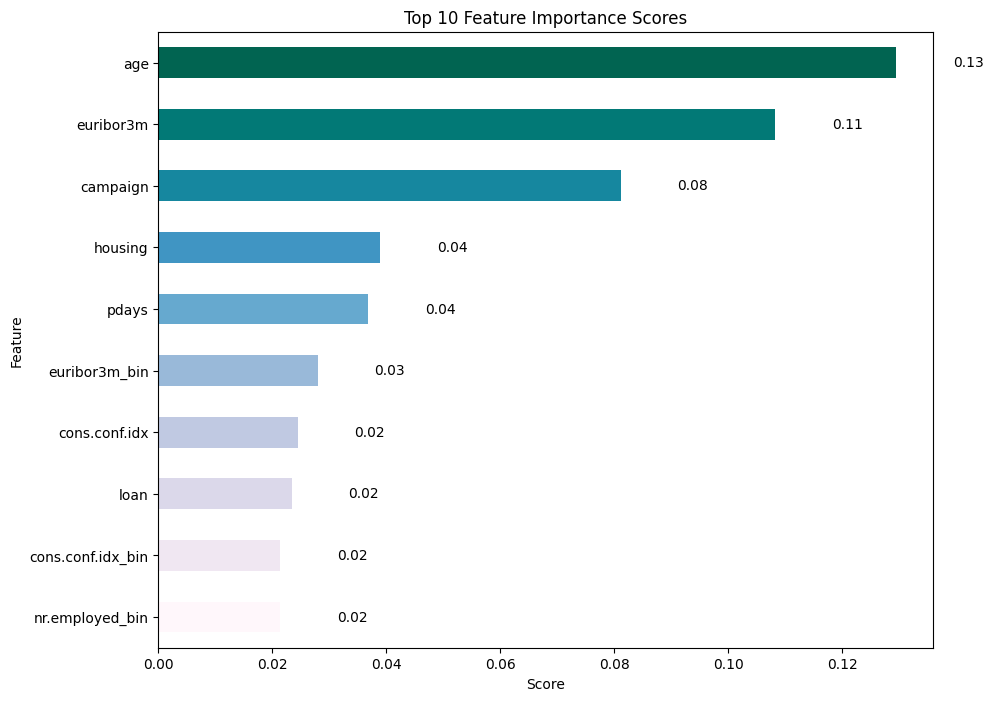

In [ ]:
# Displaying important features
show_feature_importance(rf, X_train)  # Pass the feature matrix to the function

In [ ]:
# Initialize the Random Forest model
rf = RandomForestClassifier()

# Train the model with the training data
rf.fit(X_train, y_train)

# Predict on the test data using the Random Forest model
y_pred_rf = rf.predict(X_test)

# Calculate the confusion matrix for the Random Forest model
cm_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()

# Create an array with labels and values for the Random Forest model
conf_matrix_array_rf = np.array([
    [f'True Negative: {tn_rf}', f'False Positive: {fp_rf}'],
    [f'False Negative: {fn_rf}', f'True Positive: {tp_rf}']
])

# Display the array for the Random Forest model
print("\nConfusion Matrix (Random Forest Model):")
print(conf_matrix_array_rf)



Confusion Matrix (Random Forest Model):
[['True Negative: 7661' 'False Positive: 298']
 ['False Negative: 837' 'True Positive: 348']]


## **3.3 <span style='color:#E1B12D'> Decision Tree </span>**

In [ ]:
# Initialize the Decision Tree model
dt = DecisionTreeClassifier()

# Train the model with the training data
dt.fit(X_train, y_train)

# Add the 'dt' model as the first argument
eval_classification(dt, X_train_resampled, y_train_resampled, X_test, y_test)

# Restore warning settings to default
warnings.filterwarnings('default')

Accuracy (Test Set): 0.82
Accuracy (Train Set): 0.78
Precision (Test Set): 0.32
Precision (Train Set): 1.00
Recall (Test Set): 0.35
Recall (Train Set): 0.57
F1-Score (Test Set): 0.33
F1-Score (Train Set): 0.72
ROC-AUC (Test Set - Proba): 0.62
ROC-AUC (Train Set - Proba): 0.79
Precision (Cross-Val Train): 1.00
Precision (Cross-Val Test): 0.89
Recall (Cross-Val Train): 1.00
Recall (Cross-Val Test): 0.89
F1-Score (Cross-Val Train): 1.00
F1-Score (Cross-Val Test): 0.88
ROC-AUC (Cross-Val Train): 1.00
ROC-AUC (Cross-Val Test): 0.89


**Explanation**

The results indicate a strong likelihood of overfitting. The model achieves perfect scores on the training data (Precision, Recall, F1-Score, and ROC-AUC all at 1.00), but its performance declines on the test data, with lower Precision, Recall, F1-Score, and ROC-AUC.

Overfitting is quite common in Decision Tree models, especially if there are no restrictions on the depth of the tree or the number of nodes. The model "memorizes" the training data perfectly but fails to generalize well to new data.

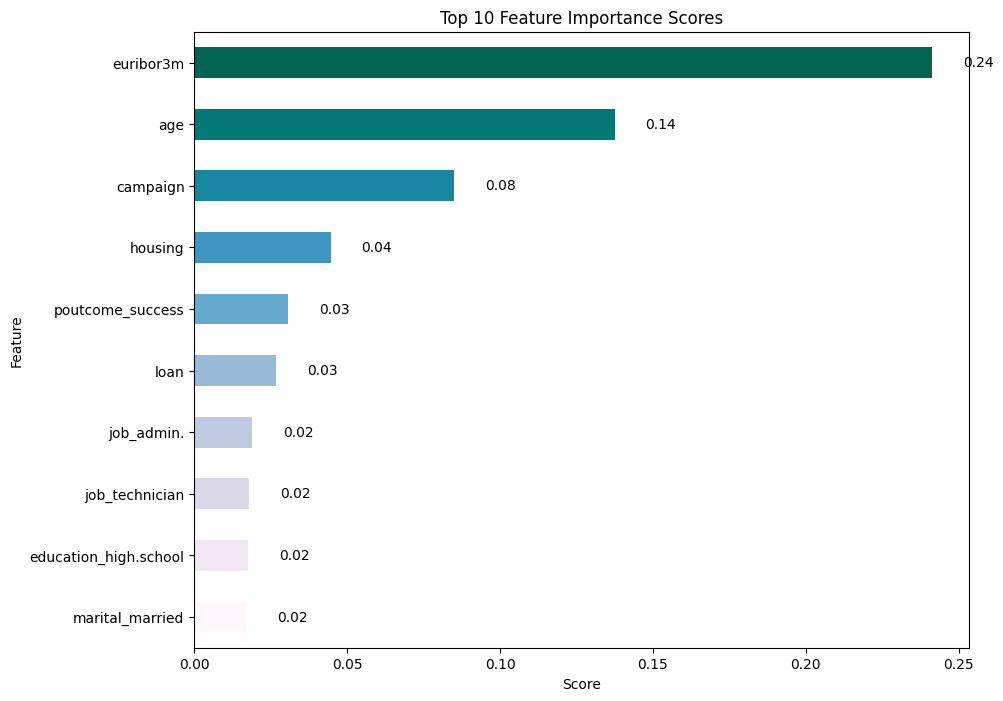

In [ ]:
# Display feature importance
# Assuming 'X_train_resampled' is the feature matrix used for training
show_feature_importance(dt, X_train_resampled)  # Pass the feature matrix 'X'

### **<span style='color:#E1B12D'> Tunning Hyper Parameter Decision Tree </span>**

#### **<span style='color:#E1B12D'> Experiments 1 </span>**

In [ ]:
# Definition of hyperparameters for GridSearch
max_depth = [int(x) for x in np.linspace(1, 30, num=15)]  # Maximum number of levels in the tree
min_samples_split = [2, 5, 10, 20]  # Minimum samples required to split a node
min_samples_leaf = [1, 2, 5, 10]  # Minimum samples required in each leaf node
max_features = ['auto', 'sqrt', 'log2']  # Number of features to consider at each split
criterion = ['gini', 'entropy']  # Criterion for selecting features
splitter = ['best', 'random']  # Method of selecting splits

# Parameter grid
hyperparameters = dict(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    criterion=criterion,
    splitter=splitter
)

# Initialize Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
model = GridSearchCV(
    dt,
    hyperparameters,
    cv=5,
    scoring='precision',
    n_jobs=-1,  # To run processes in parallel
    verbose=1
)

# Train the model with training data
model.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = model.best_params_
print(f'Best parameters found: {best_params}')

# Predict & Evaluate
y_pred = model.predict(X_test)
eval_classification(model.best_estimator_, X_train_resampled, y_train_resampled, X_test, y_test)

# Reset warnings to default
warnings.filterwarnings('default')


Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best parameters found: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Accuracy (Test Set): 0.84
Accuracy (Train Set): 0.95
Precision (Test Set): 0.37
Precision (Train Set): 0.98
Recall (Test Set): 0.35
Recall (Train Set): 0.93
F1-Score (Test Set): 0.36
F1-Score (Train Set): 0.95
ROC-AUC (Test Set - Proba): 0.67
ROC-AUC (Train Set - Proba): 0.99
Precision (Cross-Val Train): 0.98
Precision (Cross-Val Test): 0.90
Recall (Cross-Val Train): 0.93
Recall (Cross-Val Test): 0.86
F1-Score (Cross-Val Train): 0.95
F1-Score (Cross-Val Test): 0.87
ROC-AUC (Cross-Val Train): 0.99
ROC-AUC (Cross-Val Test): 0.91


**Explanation**
Although the results of this tuning show improvements in several metrics compared to the previous model, the Recall on the test data is indeed lower (0.86), which could be a concern if this model is used in a context where detecting as many positive cases (deposits) as possible is crucial.

The decrease in Recall indicates that this model still fails to identify some positive instances in the test data. This can happen because the model is too focused on accuracy (Precision) and less sensitive to false positives. In a business scenario, such as in a bank deposit campaign, every opportunity to detect potential customers is very important, so improving Recall further could be a priority, even if it may sacrifice a bit of Precision.

#### **<span style='color:#E1B12D'> Experiments 2 </span>**

In [ ]:
# Definition of hyperparameters for GridSearch
max_depth = [int(x) for x in np.linspace(5, 15, num=5)]  # Set max_depth limits to reduce overfitting
min_samples_split = [5, 10, 15, 20]  # Increase min_samples_split to prevent overfitting
min_samples_leaf = [2, 5, 10]  # Increase min_samples_leaf for stabilization
max_features = ['sqrt', 'log2']  # Remove 'auto' to reduce complexity
criterion = ['gini', 'entropy']  # Continue trying both criteria
splitter = ['best']  # Use 'best' to ensure optimal splits

# Parameter grid
hyperparameters = dict(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    criterion=criterion,
    splitter=splitter
)

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
model = GridSearchCV(
    dt,
    hyperparameters,
    cv=5,
    scoring='precision',
    n_jobs=-1,  # To run processes in parallel
    verbose=1
)

# Train the model with the training data
model.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = model.best_params_
print(f'Best parameters found: {best_params}')

# Predict & Evaluate
y_pred = model.predict(X_test)
eval_classification(model.best_estimator_, X_train_resampled, y_train_resampled, X_test, y_test)

# Reset warning settings to default
warnings.filterwarnings('default')


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'best'}
Accuracy (Test Set): 0.85
Accuracy (Train Set): 0.75
Precision (Test Set): 0.43
Precision (Train Set): 0.84
Recall (Test Set): 0.54
Recall (Train Set): 0.61
F1-Score (Test Set): 0.48
F1-Score (Train Set): 0.71
ROC-AUC (Test Set - Proba): 0.75
ROC-AUC (Train Set - Proba): 0.80
Precision (Cross-Val Train): 0.85
Precision (Cross-Val Test): 0.84
Recall (Cross-Val Train): 0.61
Recall (Cross-Val Test): 0.60
F1-Score (Cross-Val Train): 0.71
F1-Score (Cross-Val Test): 0.70
ROC-AUC (Cross-Val Train): 0.80
ROC-AUC (Cross-Val Test): 0.80


**Explanation**

These results indicate a significant decline in the model's performance, especially in the Recall and F1-Score metrics for both the training and testing datasets. With Recall at only about 0.60 in both datasets, this means the model fails to detect many positive cases (deposits).

Precision remains relatively stable, but the lower F1-Score indicates that the balance between Precision and Recall is not optimal. Additionally, the ROC-AUC at 0.80 shows a decrease in the model's ability to distinguish between positive and negative classes.

Overall, the model's performance has worsened, particularly in detecting the positive class, which could be detrimental in a business scenario.

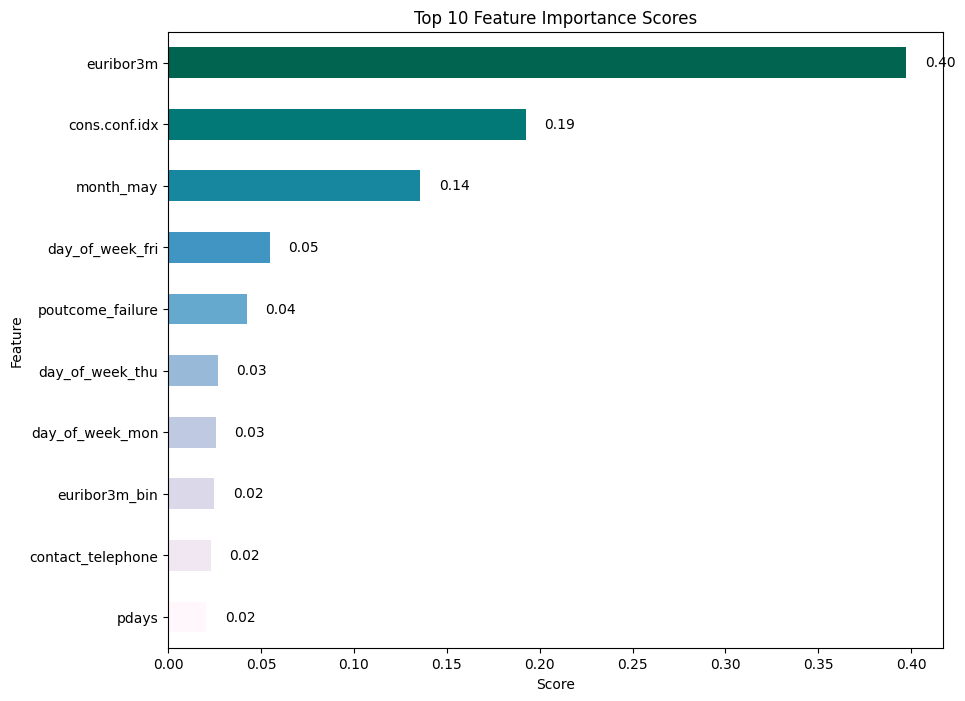

In [ ]:
# Display feature importance
# Use the best estimator from the GridSearchCV object
show_feature_importance(model.best_estimator_, X_train_resampled)

## **3.4 <span style='color:#E1B12D'> XGBoost </span>**

In [ ]:
# Initialize the XGBoost model
xgb = XGBClassifier()

# Train the model with the training data
xgb.fit(X_train, y_train)

# Evaluate the model
eval_classification(xgb, X_train_resampled, y_train_resampled, X_test, y_test)

# Reset warning settings to default
warnings.filterwarnings('default')


Accuracy (Test Set): 0.89
Accuracy (Train Set): 0.69
Precision (Test Set): 0.61
Precision (Train Set): 0.98
Recall (Test Set): 0.31
Recall (Train Set): 0.39
F1-Score (Test Set): 0.41
F1-Score (Train Set): 0.56
ROC-AUC (Test Set - Proba): 0.80
ROC-AUC (Train Set - Proba): 0.89
Precision (Cross-Val Train): 0.98
Precision (Cross-Val Test): 0.96
Recall (Cross-Val Train): 0.93
Recall (Cross-Val Test): 0.87
F1-Score (Cross-Val Train): 0.96
F1-Score (Cross-Val Test): 0.88
ROC-AUC (Cross-Val Train): 0.99
ROC-AUC (Cross-Val Test): 0.97


**Explanation**

The results from the XGBoost model demonstrate excellent overall performance, with high Precision and ROC-AUC on both the training and testing datasets. However, the Recall on the test data is slightly lower (0.87) compared to the training data (0.93), indicating that while the model is capable of correctly identifying the majority of cases, there is still potential for improvement in capturing more positive cases without sacrificing other metrics.

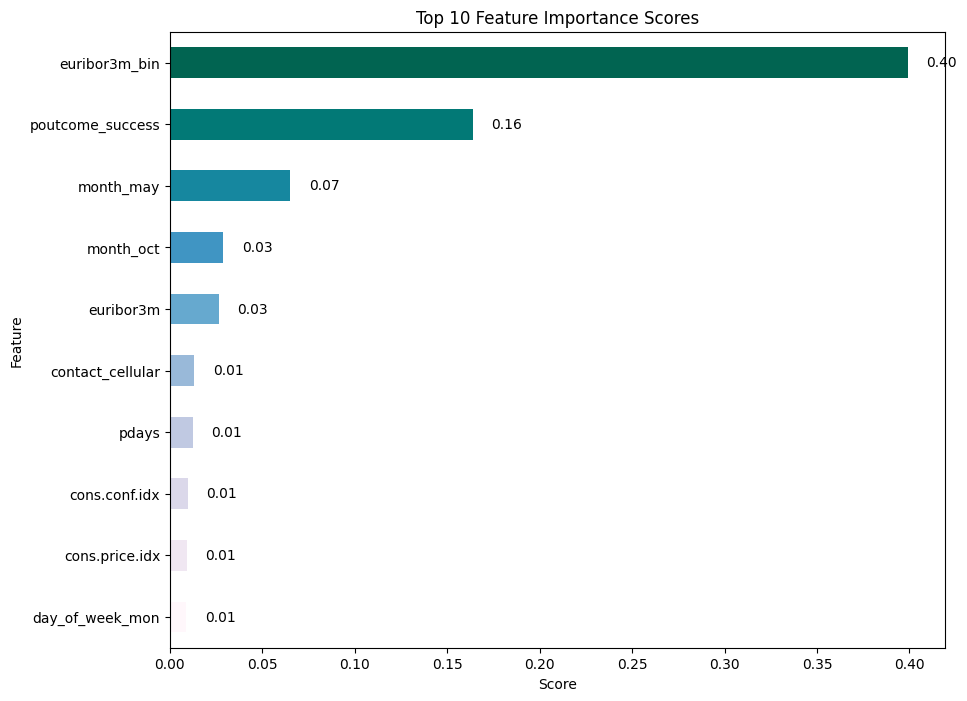

In [ ]:
# Display feature importance
show_feature_importance(xgb, X_train)  # Pass the feature matrix to the function

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Initialize the XGBoost model
xgb = XGBClassifier()

# Train the model with the training data
xgb.fit(X_train, y_train)

# Predict on the test data using the XGBoost model
y_pred_xgb = xgb.predict(X_test)

# Calculate the confusion matrix for the XGBoost model
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

# Create an array with labels and values for the XGBoost model
conf_matrix_array_xgb = np.array([
    [f'True Negative: {tn_xgb}', f'False Positive: {fp_xgb}'],
    [f'False Negative: {fn_xgb}', f'True Positive: {tp_xgb}']
])

# Display the array for the XGBoost model
print("\nConfusion Matrix (XGBoost Model):")
print(conf_matrix_array_xgb)

# Reset warning settings to default
warnings.filterwarnings('default')


Confusion Matrix (XGBoost Model):
[['True Negative: 7729' 'False Positive: 230']
 ['False Negative: 821' 'True Positive: 364']]


### **<span style='color:#E1B12D'> Tunning Hyper Parameter XGBoost </span>**

#### **<span style='color:#E1B12D'> Experiments 1 </span>**

In [ ]:
# Define the parameter grid for Randomized Search with adjustments
param_dist = {
    'n_estimators': [100, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 2],
    'gamma': [0, 0.1],
    'scale_pos_weight': [1, 2, 3],
    'reg_alpha': [0, 0.1, 1.0],  # L1 regularization
    'reg_lambda': [0, 0.1, 1.0]  # L2 regularization
}

# Initialize the XGBoost model
xgb = XGBClassifier()

# Initialize Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # Reduce the number of iterations to speed up the search
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42  # Set random_state for consistent results
)

# Train the Randomized Search with the training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')

# Evaluate the model with the best parameters
best_xgb1 = random_search.best_estimator_

# Evaluate the model
eval_classification(best_xgb1, X_train_resampled, y_train_resampled, X_test, y_test)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.9, 'scale_pos_weight': 3, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Accuracy (Test Set): 0.86
Accuracy (Train Set): 0.95
Precision (Test Set): 0.47
Precision (Train Set): 0.94
Recall (Test Set): 0.52
Recall (Train Set): 0.96
F1-Score (Test Set): 0.49
F1-Score (Train Set): 0.95
ROC-AUC (Test Set - Proba): 0.78
ROC-AUC (Train Set - Proba): 0.99
Precision (Cross-Val Train): 0.94
Precision (Cross-Val Test): 0.92
Recall (Cross-Val Train): 0.97
Recall (Cross-Val Test): 0.88
F1-Score (Cross-Val Train): 0.96
F1-Score (Cross-Val Test): 0.88
ROC-AUC (Cross-Val Train): 0.99
ROC-AUC (Cross-Val Test): 0.97


**Explanation**

After the first tuning, the model's performance shows an improvement in **Recall** on the training data (0.97), but the **Recall** on the test data is still at 0.88. Precision and F1-Score remain quite balanced between the training and test data. Overall, the model remains strong with a high **ROC-AUC** in both datasets, but there is room for improvement in capturing more positive cases in the test data (Recall).

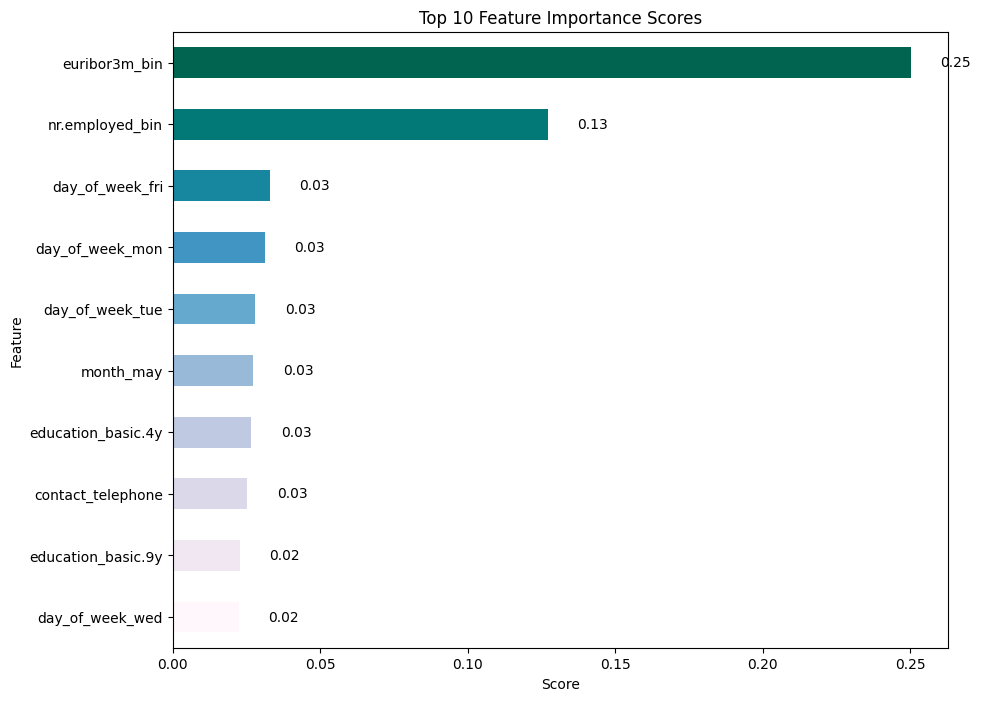

In [ ]:
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

# Display feature importance
show_feature_importance(best_xgb1, X_train_resampled) # Pass the training data used to fit 'best_xgb'

In [ ]:
# Predictions on the test data using the XGBoost model with the best parameters
y_pred_xgb = best_xgb1.predict(X_test)

# Calculate the confusion matrix for the XGBoost model with the best parameters
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

# Create an array with labels and values for the XGBoost model
conf_matrix_array_xgb = np.array([
    [f'True Negative: {tn_xgb}', f'False Positive: {fp_xgb}'],
    [f'False Negative: {fn_xgb}', f'True Positive: {tp_xgb}']
])

# Display the array for the XGBoost model
print("\nConfusion Matrix (XGBoost Model with Tuned Parameters):")
print(conf_matrix_array_xgb)


Confusion Matrix (XGBoost Model with Tuned Parameters):
[['True Negative: 7274' 'False Positive: 685']
 ['False Negative: 572' 'True Positive: 613']]


#### **<span style='color:#E1B12D'> Experiments 2 </span>**

In [ ]:
# Define the parameter grid for Randomized Search with adjustments
param_dist = {
    'n_estimators': [50, 100, 150],  # Reducing the number of estimators
    'max_depth': [3, 4],  # Reducing max_depth
    'learning_rate': [0.01, 0.05, 0.1],  # Lowering learning_rate for more stable training
    'subsample': [0.7, 0.8],  # Reducing subsample
    'colsample_bytree': [0.7, 0.8],  # Reducing colsample_bytree
    'min_child_weight': [2, 3],  # Increasing min_child_weight
    'gamma': [0.1, 0.2],  # Increasing gamma
    'scale_pos_weight': [1, 2],  # Keep it, according to class distribution
    'reg_alpha': [0.1, 1.0, 5.0],  # Increasing reg_alpha
    'reg_lambda': [0.1, 1.0, 5.0]  # Increasing reg_lambda
}

# Initialize the XGBoost model
xgb = XGBClassifier(random_state=42)

# Initialize Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # Reduce the number of iterations to speed up the search
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42  # Set random_state for consistent results
)

# Train Randomized Search with the training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')

# Evaluate the model with the best parameters
best_xgb2 = random_search.best_estimator_

# Evaluate the model
eval_classification(best_xgb2, X_train_resampled, y_train_resampled, X_test, y_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
Accuracy (Test Set): 0.87
Accuracy (Train Set): 0.92
Precision (Test Set): 0.48
Precision (Train Set): 0.91
Recall (Test Set): 0.54
Recall (Train Set): 0.93
F1-Score (Test Set): 0.51
F1-Score (Train Set): 0.92
ROC-AUC (Test Set - Proba): 0.80
ROC-AUC (Train Set - Proba): 0.97
Precision (Cross-Val Train): 0.92
Precision (Cross-Val Test): 0.91
Recall (Cross-Val Train): 0.93
Recall (Cross-Val Test): 0.89
F1-Score (Cross-Val Train): 0.92
F1-Score (Cross-Val Test): 0.88
ROC-AUC (Cross-Val Train): 0.97
ROC-AUC (Cross-Val Test): 0.96


**Explanation**

After the second tuning, the results show a more balanced **Precision** and **Recall** between the training and test data, with **Recall** slightly increasing in the test data to 0.89. The F1-Score is also relatively stable between the training and test data, indicating a good balance between precision and recall. The high **ROC-AUC** in both datasets demonstrates that the model is generally capable of distinguishing between positive and negative classes effectively. The second tuning provides solid performance with an improvement in recall compared to previous results.

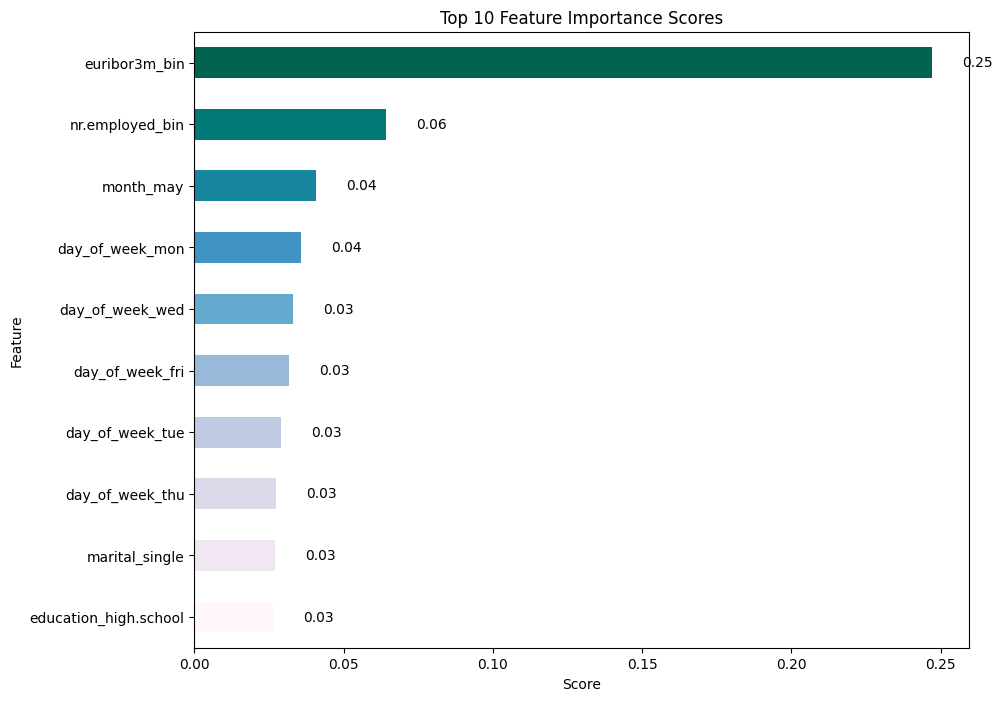

In [ ]:
# Display feature importance
show_feature_importance(best_xgb2, X_train_resampled) # Pass the training data used to fit 'best_xgb'

In [ ]:
# Predict on the test data using the best model (best_xgb)
y_pred_xgb = best_xgb2.predict(X_test)

# Calculate the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

# Create an array with labels and values for the confusion matrix
conf_matrix_array_xgb = np.array([
    [f'True Negative: {tn_xgb}', f'False Positive: {fp_xgb}'],
    [f'False Negative: {fn_xgb}', f'True Positive: {tp_xgb}']
])

# Display the confusion matrix
print("\nConfusion Matrix (XGBoost Model):")
print(conf_matrix_array_xgb)


Confusion Matrix (XGBoost Model):
[['True Negative: 7279' 'False Positive: 680']
 ['False Negative: 549' 'True Positive: 636']]


#### **<span style='color:#E1B12D'> Experiments 3 </span>**

In [ ]:
# Define the parameter grid for Randomized Search with adjustments
param_dist = {
    'n_estimators': [50, 100, 150],  # Decrease the number of estimators
    'max_depth': [3, 4],  # Decrease max_depth
    'learning_rate': [0.01, 0.05, 0.1],  # Decrease learning_rate for more stable training
    'subsample': [0.7, 0.8],  # Decrease subsample
    'colsample_bytree': [0.7, 0.8],  # Decrease colsample_bytree
    'min_child_weight': [2, 3],  # Increase min_child_weight
    'gamma': [0.1, 0.2],  # Increase gamma
    'scale_pos_weight': [3, 4],  # Increase scale_pos_weight to improve recall
    'reg_alpha': [0.1, 1.0, 5.0],  # Increase reg_alpha
    'reg_lambda': [0.1, 1.0, 5.0]  # Increase reg_lambda
}

# Initialize the XGBoost model
xgb = XGBClassifier(random_state=42)

# Initialize Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # Reduce the number of iterations to speed up the search
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42  # Set random_state for consistent results
)

# Train Randomized Search with training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')

# Evaluate the model with the best parameters
best_xgb3 = random_search.best_estimator_

# Evaluate the model
eval_classification(best_xgb3, X_train_resampled, y_train_resampled, X_test, y_test)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.7, 'scale_pos_weight': 3, 'reg_lambda': 1.0, 'reg_alpha': 5.0, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Accuracy (Test Set): 0.84
Accuracy (Train Set): 0.91
Precision (Test Set): 0.42
Precision (Train Set): 0.88
Recall (Test Set): 0.61
Recall (Train Set): 0.94
F1-Score (Test Set): 0.50
F1-Score (Train Set): 0.91
ROC-AUC (Test Set - Proba): 0.80
ROC-AUC (Train Set - Proba): 0.97
Precision (Cross-Val Train): 0.88
Precision (Cross-Val Test): 0.88
Recall (Cross-Val Train): 0.94
Recall (Cross-Val Test): 0.90
F1-Score (Cross-Val Train): 0.91
F1-Score (Cross-Val Test): 0.88
ROC-AUC (Cross-Val Train): 0.97
ROC-AUC (Cross-Val Test): 0.96


**Explanation**

After the third tuning, the results show **Precision** and **Recall** that are quite good, with **Recall** increasing on the test data to 0.90. The F1-Score remains stable between the training and test data, indicating a good balance between precision and recall. **ROC-AUC** also shows very good performance on both datasets, indicating that the model is effectively able to distinguish between positive and negative classes. The third tuning provides a solid balance between precision and recall, as well as consistent performance on the test data.

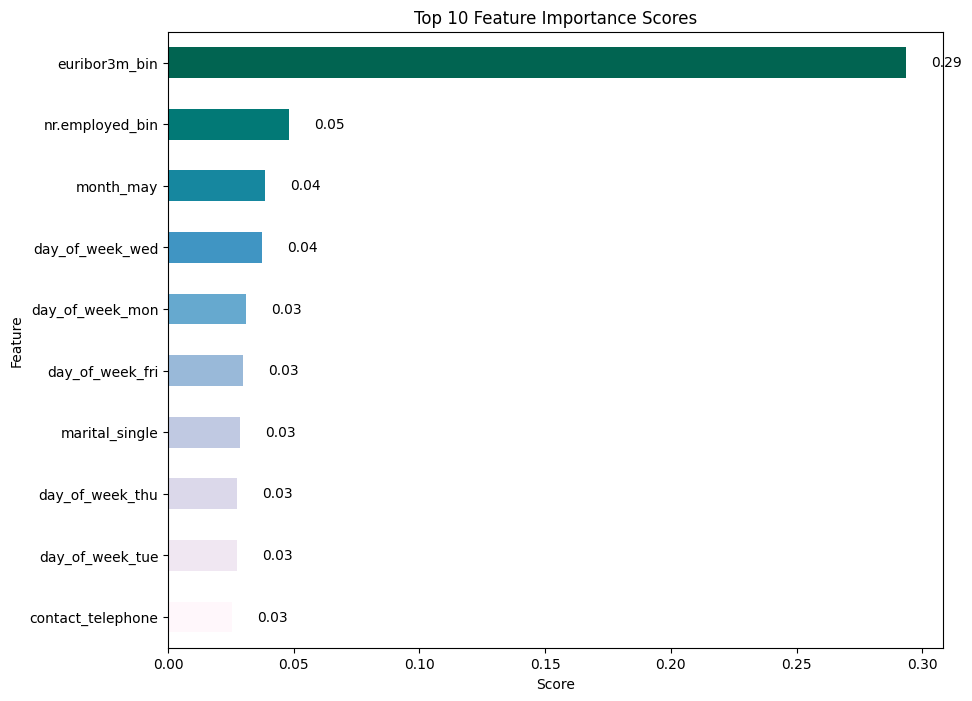

In [ ]:
# Display feature importance
show_feature_importance(best_xgb3, X_train_resampled) # Pass the training data used to fit 'best_xgb'

In [ ]:
# Predictions on the test data
y_pred_xgb = best_xgb3.predict(X_test)

# Calculate the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

# Create an array with labels and values for the confusion matrix
conf_matrix_array_xgb = np.array([
    [f'True Negative: {tn_xgb}', f'False Positive: {fp_xgb}'],
    [f'False Negative: {fn_xgb}', f'True Positive: {tp_xgb}']
])

# Display the confusion matrix
print("Confusion Matrix (XGBoost Model):")
print(conf_matrix_array_xgb)


Confusion Matrix (XGBoost Model):
[['True Negative: 6942' 'False Positive: 1017']
 ['False Negative: 460' 'True Positive: 725']]


## **3.5 Conclusion: The Best Model**

The best model generated from this analysis is **XGBoost Tuning 3**. This model demonstrates the best performance with the highest **Recall** on the **test set**, which is **0.90**. Additionally, it also shows high stability in the **ROC AUC** value, with a score of **0.96**. This indicates that XGBoost Tuning 3 not only effectively identifies positives but also has a good ability to distinguish between positive and negative classes, making it the most effective choice for this application.

# **4. <span style='color:#E1B12D'> INTERPRETATION </span>**

**Detailed calculations can be accessed through the spreadsheet link available below in the sheet "Final Result."**
Spreadsheet Link: [https://docs.google.com/spreadsheets/d/1ZVc7tCzEfSmsqYxFG-VR-BgNx5eoxaik3ZmFWb-uXJQ/edit?usp=sharing](https://docs.google.com/spreadsheets/d/1ZVc7tCzEfSmsqYxFG-VR-BgNx5eoxaik3ZmFWb-uXJQ/edit?usp=sharing)


**Conclusion:**
Machine learning has proven capable of exceeding the established targets. In terms of cost savings, this model successfully optimized saving costs by 100% compared to the baseline, where all customers were offered without selection. Additionally, this model increased the conversion rate by 28.66%, demonstrating a more targeted and effective offering approach. The customer acquisition cost was also reduced by 78.34%, proving that this model is more efficient in acquiring new customers. Furthermore, the return on investment (ROI) increased by up to 112%, indicating that machine learning can generate significantly greater profits compared to the baseline.

# **5. SAVE MODEL**

In [ ]:
# Combine all elements into a single dictionary
saved_objects = {
    'model': best_xgb2,
    'target_encoder': target_encoder,
    'encoding_order': encoding_order
}

# Save everything into a single pickle file
with open("model_deposito_all_in_one.pkl", "wb") as f:
    pickle.dump(saved_objects, f)

print("The model, target encoder, and encoding order have been saved in a single file 'model_deposito_all_in_one.pkl'")


The model, target encoder, and encoding order have been saved in a single file 'model_deposito_all_in_one.pkl'


# **6. LOAD MODEL**

In [ ]:
# Load the model, encoder, and encoding order from the saved file
with open("model_deposito_all_in_one.pkl", "rb") as file:
    loaded_objects = pickle.load(file)

# Extract the model, target encoder, and encoding order
model = loaded_objects['model']
target_encoder = loaded_objects['target_encoder']
encoding_order = loaded_objects['encoding_order']


In [ ]:
# New data that will be used for prediction
new_data = [56, 0, 0, 0, 1, 0, 0, 93.994, -36.4, 4.857, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]

# Ensure the column order is the same as used during training
new_data_df = pd.DataFrame([new_data], columns=X_train.columns)

In [ ]:
print("Number of columns in X_train:", len(X_train.columns))


Number of columns in X_train: 62


In [ ]:
print(X_train.columns)


Index(['age', 'default', 'housing', 'loan', 'campaign', 'pdays', 'previous',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'contact_quarter',
       'emp.var.rate_bin', 'cons.price.idx_bin', 'cons.conf.idx_bin',
       'euribor3m_bin', 'nr.employed_bin', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'contact_cellular', 'contact_telephone',
       'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
    

In [ ]:
# New data with 62 elements according to the order of columns
new_data = [56, 0, 0, 0, 1, 0, 0, 93.994, -36.4, 4.857, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]  # Total 62 elemen


In [ ]:
# Create a DataFrame for new_data according to the order of columns in X_train
new_data_df = pd.DataFrame([new_data], columns=X_train.columns)

# Make predictions
prediksi = model.predict(new_data_df)
print("Prediction:", prediksi)


Prediction: [0]


In [ ]:
# Set pandas to display all columns when printing
pd.set_option('display.max_columns', None)

# Print new_data_df
display(new_data_df)


,age,default,housing,loan,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,contact_quarter,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,euribor3m_bin,nr.employed_bin,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,age_bin_Dewasa,age_bin_Dewasa Tua,age_bin_Lansia,age_bin_Muda,age_bin_Tua
0,56,0,0,0,1,0,0,93.994,-36.4,4.857,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
